# 2D Template Matching

In [83]:
import time# Sys
import sys
import os

# Numerical
import numpy as np
import mrcfile
import healpy as hp
# Plotting
import matplotlib.pyplot as plt
# Signal proc / Linalg
from scipy import ndimage
from scipy import signal
from scipy.ndimage import rotate
from scipy.fftpack import fft2, ifft2, fftshift
from skimage import filters, feature, transform
# Optimization
import multiprocessing
from itertools import product

In [84]:
def read_mrc_file(file_path):
    """Reads a volume from an MRC file."""
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)
    try:
        with mrcfile.open(file_path, permissive=True) as mrc:
            volume = mrc.data.astype(np.float32)
            voxel_size = mrc.voxel_size
            if volume.ndim != 3:
                print("Error: Input volume is not 3-dimensional.")
                sys.exit(1)
    except Exception as e:
        print(f"Error reading MRC file: {e}")
        sys.exit(1)
    return volume, voxel_size

def write_mrcs_file(file_path, data_stack, voxel_size):
    """Writes a stack of images to an .mrcs file."""
    try:
        with mrcfile.new(file_path, overwrite=True) as mrc:
            mrc.set_data(data_stack)
            mrc.voxel_size = voxel_size
            # Set header fields
            mrc.header.map = b'MAP '
            mrc.header.machst = [68, 65, 0, 0]  # Machine stamp
            mrc.header.nx = data_stack.shape[2]
            mrc.header.ny = data_stack.shape[1]
            mrc.header.nz = data_stack.shape[0]
            mrc.header.mode = 2  # Mode 2 for float32 data
            mrc.header.mx = data_stack.shape[2]
            mrc.header.my = data_stack.shape[1]
            mrc.header.mz = data_stack.shape[0]
            mrc.header.cella = [voxel_size[0] * data_stack.shape[2],
                                voxel_size[1] * data_stack.shape[1],
                                voxel_size[2] * data_stack.shape[0]]
            mrc.header.mapc = 1
            mrc.header.mapr = 2
            mrc.header.maps = 3
            mrc.update_header_from_data()
    except Exception as e:
        print(f"Error writing MRCS file: {e}")
        sys.exit(1)

def rotate_and_project(volume, phi, theta, psi):
    """Rotates the volume and projects it along the Z-axis."""
    # Rotate volume by theta around Y-axis
    rotated = rotate(volume, angle=theta, axes=(0, 2), reshape=False, order=1)
    # Rotate volume by phi around Z-axis
    rotated = rotate(rotated, angle=phi, axes=(1, 0), reshape=False, order=1)
    # Rotate volume by psi around Z-axis (in-plane rotation)
    rotated = rotate(rotated, angle=psi, axes=(1, 0), reshape=False, order=1)
    # Project along Z-axis
    projection = np.sum(rotated, axis=0)
    return projection

def check_volume_dimensions(volume):
    """Checks if the volume dimensions are consistent."""
    if volume.ndim != 3:
        print("Error: Input volume is not 3-dimensional.")
        sys.exit(1)
    if volume.shape[0] != volume.shape[1] or volume.shape[1] != volume.shape[2]:
        print("Warning: Volume dimensions are not equal.")
    return volume.shape

def generate_healpix_pixel_bounds(nside):
    """Generates boundaries of theta and phi for each Healpix pixel."""
    npix = hp.nside2npix(nside)
    pixel_bounds = []
    for pix in range(npix):
        # Get the boundary vertices for this pixel
        vertices = hp.boundaries(nside, pix, step=1, nest=False)  # shape (3, N)
        # Convert x, y, z to theta, phi
        theta_vertices, phi_vertices = hp.vec2ang(vertices.T)  # Transpose to shape (N, 3)
        # Adjust phi to be in [0, 2π)
        phi_vertices = phi_vertices % (2 * np.pi)
        # Handle phi wrapping around 0 and 2π
        phi_diff = np.diff(np.sort(phi_vertices))
        if np.any(phi_diff > np.pi):
            # Correct for wrapping
            phi_vertices[phi_vertices < np.pi] += 2 * np.pi
        # Update min and max after correction
        phi_min = phi_vertices.min() % (2 * np.pi)
        phi_max = phi_vertices.max() % (2 * np.pi)
        theta_min = theta_vertices.min()
        theta_max = theta_vertices.max()
        pixel_bounds.append((theta_min, theta_max, phi_min, phi_max))
    return pixel_bounds

def generate_angles_in_pixel(theta_min, theta_max, phi_min, phi_max, angular_spacing_rad):
    # Generate theta values from theta_min to theta_max with steps of angular_spacing_rad
    theta_vals = np.arange(theta_min, theta_max, angular_spacing_rad)
    # Handle phi wrapping
    if phi_max >= phi_min:
        phi_vals = np.arange(phi_min, phi_max, angular_spacing_rad)
    else:
        # phi_max < phi_min due to wrapping around 2π
        phi_vals_part1 = np.arange(phi_min, 2 * np.pi, angular_spacing_rad)
        phi_vals_part2 = np.arange(0, phi_max, angular_spacing_rad)
        phi_vals = np.concatenate((phi_vals_part1, phi_vals_part2))
    # Create grid of theta and phi values
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing='ij')
    # Adjust phi_grid to be in [0, 2π)
    phi_grid = phi_grid % (2 * np.pi)
    return theta_grid.flatten(), phi_grid.flatten()

def generate_all_angles(nside, angular_spacing_deg):
    angular_spacing_rad = np.radians(angular_spacing_deg)
    pixel_bounds = generate_healpix_pixel_bounds(nside)
    phi_angles_list = []
    theta_angles_list = []
    for idx, (theta_min, theta_max, phi_min, phi_max) in enumerate(pixel_bounds):
        theta_vals, phi_vals = generate_angles_in_pixel(
            theta_min, theta_max, phi_min, phi_max, angular_spacing_rad
        )
        phi_angles_list.append(phi_vals)
        theta_angles_list.append(theta_vals)
        print(f"Pixel {idx + 1}/{len(pixel_bounds)}: Generated {len(theta_vals)} angles")
    # Concatenate all angles
    phi_angles = np.concatenate(phi_angles_list)
    theta_angles = np.concatenate(theta_angles_list)
    return phi_angles, theta_angles

def plot_sphere_coverage(theta_angles, phi_angles):
    """
    Plots the coverage of theta and phi angle pairs on a sphere surface (S²).

    Parameters:
    - theta_angles: array-like, polar angles in radians (0 <= theta <= pi)
    - phi_angles: array-like, azimuthal angles in radians (0 <= phi < 2*pi)
    """
    # Convert spherical coordinates to Cartesian coordinates for plotting
    x = np.sin(theta_angles) * np.cos(phi_angles)
    y = np.sin(theta_angles) * np.sin(phi_angles)
    z = np.cos(theta_angles)

    # Create a new figure and a 3D Axes
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the sphere surface for reference
    u = np.linspace(0, 2 * np.pi, 100)   # Azimuthal angle
    v = np.linspace(0, np.pi, 100)       # Polar angle
    X = np.outer(np.sin(v), np.cos(u))
    Y = np.outer(np.sin(v), np.sin(u))
    Z = np.outer(np.cos(v), np.ones_like(u))
    ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.3, edgecolor='none')

    # Plot the angle pairs on the sphere surface
    ax.scatter(x, y, z, color='red', s=5)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Sphere Coverage of Theta and Phi Angles')

    # Set equal aspect ratio for all axes
    ax.set_box_aspect([1, 1, 1])  # For matplotlib >= 3.3.0

    # Set limits to ensure the sphere is centered
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()
    

def cross_correlate_top_left(image, template):
    # Ensure the template is zero-padded to the size of the image
    template_padded = np.zeros_like(image)
    template_shape = template.shape
    # Place the template at the top-left corner of the padded array
    template_padded[:template_shape[0], :template_shape[1]] = template

    # Compute the FFTs
    image_fft = fft2(image)
    template_fft = fft2(template_padded)

    # Compute cross-correlation
    cross_corr = np.real(ifft2(image_fft * np.conj(template_fft)))

    # Normalize the cross-correlation
    # Compute local sums for normalization (using convolution with ones)
    template_sum = np.sum(template ** 2)
    image_local_sums = ndimage.uniform_filter(image ** 2, size=template_shape)
    denominator = np.sqrt(template_sum * image_local_sums)
    denominator[denominator == 0] = 1  # Prevent division by zero

    normalized_cross_corr = cross_corr / denominator
    return normalized_cross_corr

# Define the band-pass filter function
def bandpass_filter(img, low_sigma, high_sigma):
    low_pass = ndimage.gaussian_filter(img, high_sigma)
    high_pass = img - ndimage.gaussian_filter(img, low_sigma)
    return high_pass - low_pass

# Function to pad a template to the same size as the image
def pad_template_to_image(template, image_shape):
    pad_y = image_shape[0] - template.shape[0]
    pad_x = image_shape[1] - template.shape[1]
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left
    template_padded = np.pad(template, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    return template_padded

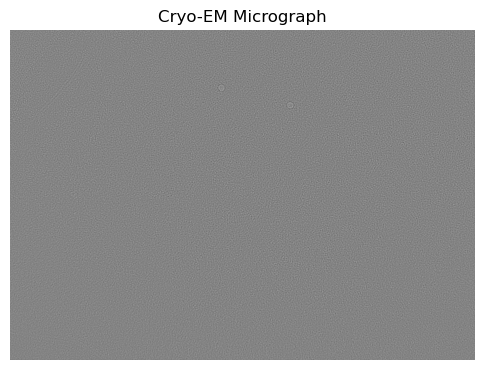

In [85]:
with mrcfile.open('0_data/00040_3_0_wctf.mrc', permissive=True) as mrc:
    I = np.squeeze(mrc.data.astype(np.float32))

# Display the Cryo-EM micrograph
plt.figure(figsize=(6, 6))
plt.imshow(I, cmap='gray')
plt.title('Cryo-EM Micrograph')
plt.axis('off')
plt.show()

In [86]:
volume_file = input("Enter the path to the input MRC volume file: ").strip()
#angular_spacing = float(input("Enter the angular spacing for Healpix sampling (in degrees): "))
#psi_step = float(input("Enter the in-plane rotation step size (psi) (in degrees): "))

In [87]:
# Read the volume
volume, voxel_size = read_mrc_file(volume_file)
vol_shape = check_volume_dimensions(volume)
projection_shape = (vol_shape[1], vol_shape[2])  # Assuming projection along Z-axis

In [88]:
# Get nside from the user
try:
    nside = int(input("Enter NSIDE parameter (must be a power of 2 integer): "))
    if not hp.isnsideok(nside):
        raise ValueError
except ValueError:
    print("Error: NSIDE must be a valid power of 2 integer.")
    sys.exit(1)

print(f"Using NSIDE = {nside} for Healpix sampling.")

# Get angular spacing from the user
try:
    angular_spacing = float(input("Enter angular spacing in degrees: "))
    if angular_spacing <= 0:
        raise ValueError
except ValueError:
    print("Error: Angular spacing must be a positive number.")
    sys.exit(1)

# Generate phi and theta angles
phi_angles, theta_angles = generate_all_angles(nside, angular_spacing)
print(f"Generated {len(phi_angles)} orientations using Healpix.")

# Generate psi angles
try:
    psi_step = float(input("Enter psi angular step in degrees: "))
    if psi_step <= 0:
        raise ValueError
except ValueError:
    print("Error: Psi angular step must be a positive number.")
    sys.exit(1)

psi_angles = np.arange(0, 360, psi_step)
print(f"Using {len(psi_angles)} in-plane rotations (psi angles).")

# Total number of projections
total_projections = len(phi_angles) * len(psi_angles)
print(f"Total number of projections to generate: {total_projections}")

Using NSIDE = 2 for Healpix sampling.
Pixel 1/48: Generated 6 angles
Pixel 2/48: Generated 12 angles
Pixel 3/48: Generated 18 angles
Pixel 4/48: Generated 6 angles
Pixel 5/48: Generated 4 angles
Pixel 6/48: Generated 4 angles
Pixel 7/48: Generated 4 angles
Pixel 8/48: Generated 4 angles
Pixel 9/48: Generated 4 angles
Pixel 10/48: Generated 4 angles
Pixel 11/48: Generated 4 angles
Pixel 12/48: Generated 4 angles
Pixel 13/48: Generated 4 angles
Pixel 14/48: Generated 4 angles
Pixel 15/48: Generated 4 angles
Pixel 16/48: Generated 4 angles
Pixel 17/48: Generated 4 angles
Pixel 18/48: Generated 4 angles
Pixel 19/48: Generated 4 angles
Pixel 20/48: Generated 4 angles
Pixel 21/48: Generated 4 angles
Pixel 22/48: Generated 4 angles
Pixel 23/48: Generated 4 angles
Pixel 24/48: Generated 4 angles
Pixel 25/48: Generated 4 angles
Pixel 26/48: Generated 4 angles
Pixel 27/48: Generated 4 angles
Pixel 28/48: Generated 4 angles
Pixel 29/48: Generated 4 angles
Pixel 30/48: Generated 4 angles
Pixel 31/

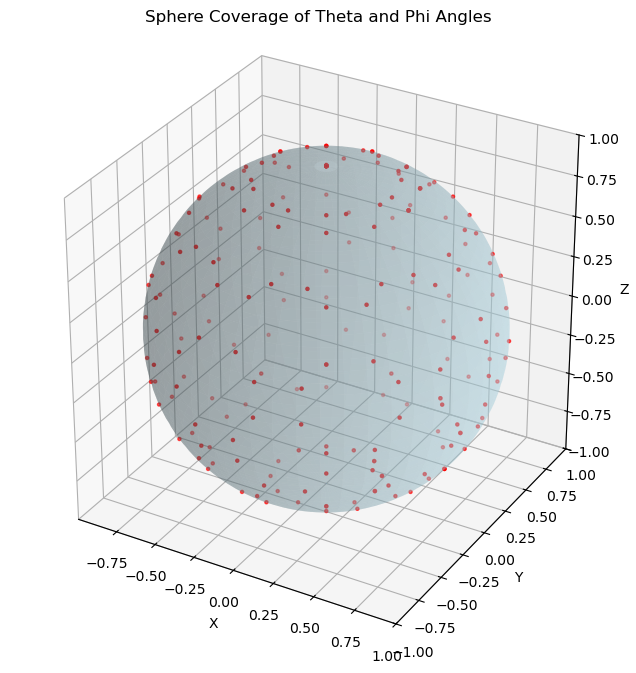

In [89]:
plot_sphere_coverage(theta_angles, phi_angles)

In [90]:
# Apply the band-pass filter to the micrograph
I_filtered = bandpass_filter(I, low_sigma=1, high_sigma=5)

# Normalize the micrograph
I_mean = np.mean(I_filtered)
I_std = np.std(I_filtered)
I_norm = (I_filtered - I_mean) / I_std

In [92]:
# Initialize arrays to store the max elements, mean, and variance
ncc_max = np.full_like(I_filtered, -np.inf, dtype=np.float32)
ncc_mean = np.zeros_like(I_filtered, dtype=np.float32)
ncc_M2 = np.zeros_like(I_filtered, dtype=np.float32)  # M2 is the sum of squares of differences from the current mean
n = 0  # Counter for the number of templates processed

comp_start = time.time()

# Loop through each template and update the max, mean, and variance
#for idx, template in enumerate(templates_rotated):
#index = 0
for i, (phi, theta) in enumerate(zip(phi_angles, theta_angles)):    
    for psi in psi_angles:
        #if n == 0: 
        #        start_time = time.time()
        # Rotate and project
        start_time = time.time()
        projection = rotate_and_project(volume, phi, theta, psi)
        end_time = time.time()
        print(f"Time taken to rotate and project : {end_time-start_time} seconds")
        # Check Dimensions
        if projection.shape != projection_shape:
                print(f"Warning: Projection dimensions {projection.shape} do not match expected shape {projection_shape}.")
        # Normalize projection
        projection = projection - np.mean(projection)
        # Band pass filter the projection
        proj_filtered = bandpass_filter(projection, low_sigma=1, high_sigma=5)
        # Normalize the filtered projection
        T_mean = np.mean(proj_filtered)
        T_std = np.std(proj_filtered)
        T_norm = (proj_filtered - T_mean) / T_std
        # Padd the projection
        #T_padded = pad_template_to_image(T_norm, I_norm.shape)
        # Perform cross correlation
        start_time = time.time()
        cross_corr = cross_correlate_top_left(I_filtered, T_norm)
        end_time = time.time()
        print(f"Time taken to calculate cross-correlation : {end_time-start_time} seconds")
        
        
        # Plot the cross-correlation result
        #plt.figure(figsize=(6, 6))
        #plt.imshow(cross_corr, cmap='gray')
        #plt.title(f'Cross-Correlation (phi={phi:.2f}, theta={theta:.2f}, psi={psi:.2f})')
        #plt.colorbar()
        #plt.axis('off')
        #plt.show()
        
        # Update max elements
        ncc_max = np.maximum(ncc_max, cross_corr)
        
        # Update mean and variance using Welford's algorithm
        n += 1
        delta = cross_corr - ncc_mean
        ncc_mean += delta / n
        delta2 = cross_corr - ncc_mean
        ncc_M2 += delta * delta2
        
        #if n % 50 == 0:
        #        end_time = time.time()
        #        print(f"Cross-correlation computation taken for 50 templates : {end_time - start_time} seconds")
        #        start_time = time.time()

# Calculate the variance
ncc_variance = ncc_M2 / (n - 1) if n > 1 else np.zeros_like(I_filtered, dtype=np.float32)

final = time.time()
elapsed_time = final - comp_start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Cross-correlation computation taken for all {n} templates: {int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds")

Time taken to rotate and project : 0.2670161724090576 seconds
Time taken to calculate cross-correlation : 0.6492247581481934 seconds
Time taken to rotate and project : 0.2522311210632324 seconds
Time taken to calculate cross-correlation : 0.6467041969299316 seconds
Time taken to rotate and project : 0.2506077289581299 seconds
Time taken to calculate cross-correlation : 0.6541492938995361 seconds
Time taken to rotate and project : 0.2635464668273926 seconds
Time taken to calculate cross-correlation : 0.6508708000183105 seconds
Time taken to rotate and project : 0.2518432140350342 seconds
Time taken to calculate cross-correlation : 0.6476731300354004 seconds
Time taken to rotate and project : 0.2543473243713379 seconds
Time taken to calculate cross-correlation : 0.6530451774597168 seconds
Time taken to rotate and project : 0.2739369869232178 seconds
Time taken to calculate cross-correlation : 0.6444635391235352 seconds
Time taken to rotate and project : 0.25588130950927734 seconds


KeyboardInterrupt: 

In [ ]:
# Display the results
plt.figure(figsize=(6, 6))
plt.imshow(ncc_max, cmap='gray')
plt.title('Max Cross-Correlation Map')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(ncc_mean, cmap='gray')
plt.title('Mean Cross-Correlation Map')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(ncc_variance, cmap='gray')
plt.title('Variance Cross-Correlation Map')
plt.colorbar()
plt.axis('off')
plt.show()


# Aggregate the correlation maps by taking the maximum at each pixel
mip = (ncc_max - ncc_mean)/np.sqrt(ncc_variance)

# Display the aggregated cross-correlation map
plt.figure(figsize=(6, 6))
plt.imshow(mip, cmap='gray')
plt.title('Aggregated MIP map')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:


# Count the number of elements above 8
num_elements_above_8 = np.sum(mip > 7.43)
print(f"Number of elements in mip_scaled above 8: {num_elements_above_8}")

In [ ]:
# Find the row and column indices of values greater than 7 in the mip array
indices = np.where(mip > 7.43)
rows, cols = indices

# Print the row and column indices in pairs
for row, col in zip(rows, cols):
    print(f"Row: {row}, Col: {col}")

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(I_filtered, cmap='gray')

# Add circles for each pair of coordinates
for col, row in zip(cols, rows):
	circle = plt.Circle((col, row), radius=50, color='red', fill=False, linewidth=0.2)
	plt.gca().add_patch(circle)

#plt.scatter(cols, rows, c='red', s=1)
plt.title('Row, Col Indices on Image I')
plt.axis('off')
plt.show()